# Lab 3 - K-means and PCA

A lab done by both:

Kaden Franklin & Ketty Dusenge

(principle component analysis)

https://hendrix-cs.github.io/csci285/labs/heart-disease.html

In [1]:
# Import pandas
import pandas as pd
pd.set_option('display.max_columns', None)

# Import seaborn
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# Import SciKitLearn functions
from sklearn.datasets import make_blobs, make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Apply the default theme
sns.set_theme()

## Step 1 - Dataset Understanding

Working with the Cleveland clinic testing dataset for diagnosing heart disease.

specifcally cleveland-testing.csv

In [2]:
c_t = pd.read_csv("cleveland-testing.csv")
c_t.head()

age  female        chest_pain  rest_bps  cholesterol  \
0   57   False      asymptomatic       140          192   
1   56    True   atypical angina       140          294   
2   56   False  non-anginal pain       130          256   
3   44   False   atypical angina       120          263   
4   52   False  non-anginal pain       172          199   

   high_fasting_blood_sugar     rest_ecg  maximum_heart_rate  exercise_angina  \
0                     False       normal                 148            False   
1                     False  hypertrophy                 153            False   
2                      True  hypertrophy                 142             True   
3                     False       normal                 173            False   
4                      True       normal                 162            False   

   vessels  heart_disease  
0        0          False  
1        0          False  
2        1           True  
3        0          False  
4        0          False

In [3]:
print(f"Number of Rows: {len(c_t)}")
print(f"Shape (rows x cols): {c_t.shape}")

Number of Rows: 293
Shape (rows x cols): (293, 11)


In [4]:
c_t.dtypes

age                          int64
female                        bool
chest_pain                  object
rest_bps                     int64
cholesterol                  int64
high_fasting_blood_sugar      bool
rest_ecg                    object
maximum_heart_rate           int64
exercise_angina               bool
vessels                      int64
heart_disease                 bool
dtype: object

In [5]:
c_t.describe()

age    rest_bps  cholesterol  maximum_heart_rate     vessels
count  293.000000  293.000000   293.000000          293.000000  293.000000
mean    54.365188  131.627986   246.522184          149.426621    0.658703
std      9.000747   17.750984    52.069603           22.877853    0.928746
min     29.000000   94.000000   126.000000           71.000000    0.000000
25%     48.000000  120.000000   211.000000          133.000000    0.000000
50%     55.000000  130.000000   241.000000          152.000000    0.000000
75%     61.000000  140.000000   275.000000          166.000000    1.000000
max     77.000000  200.000000   564.000000          202.000000    3.000000

## 1.1 Categorical Analysis

In [6]:
c_t['chest_pain'].value_counts()

asymptomatic        138
non-anginal pain     85
atypical angina      48
typical angina       22
Name: chest_pain, dtype: int64

In [7]:
c_t['rest_ecg'].value_counts()

normal              148
hypertrophy         141
wave abnormality      4
Name: rest_ecg, dtype: int64

In [8]:
c_t['heart_disease'].value_counts()

False    159
True     134
Name: heart_disease, dtype: int64

In [9]:
# three categorical against five numeric
# 'chest_pain', 'rest_ecg', 'heart_disease'
# 'age', 'rest_bps', 'cholesteral', 'maximum_heart_rate', 'vessels'

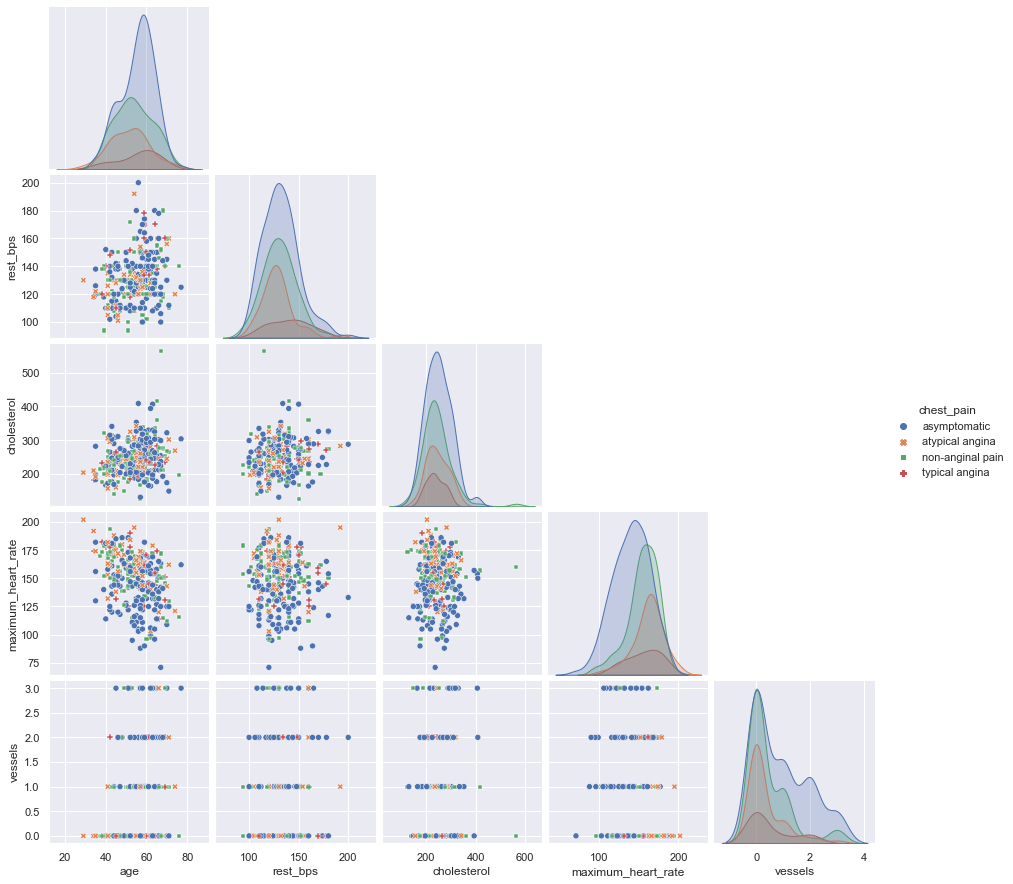

In [10]:
# dis = ['chest_pain', 'rest_ecg', 'heart_disease']
# dat = ['age', 'rest_bps', 'cholesterol', 'maximum_heart_rate', 'vessels']

# for x, y in enumerate(dat):
#     sns.pairplot(c_t, x_vars= dis[x], y_vars= y )
    
plot = sns.pairplot(
    data = c_t[['age', 'rest_bps', 'cholesterol', 'maximum_heart_rate', 'vessels', 'chest_pain']],
    hue = 'chest_pain',
    markers = True,
    corner = True
)


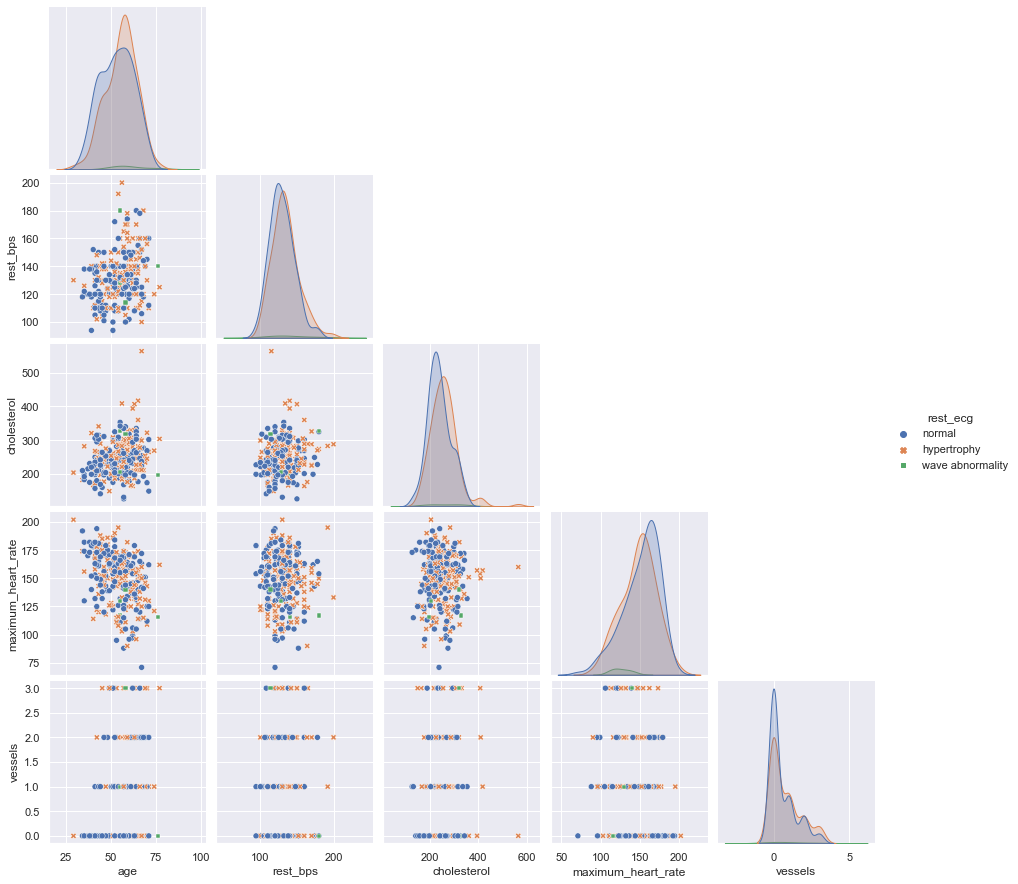

In [11]:
plot = sns.pairplot(
    data = c_t[['age', 'rest_bps', 'cholesterol', 'maximum_heart_rate', 'vessels', 'rest_ecg']],
    hue = 'rest_ecg',
    markers = True,
    corner = True
)


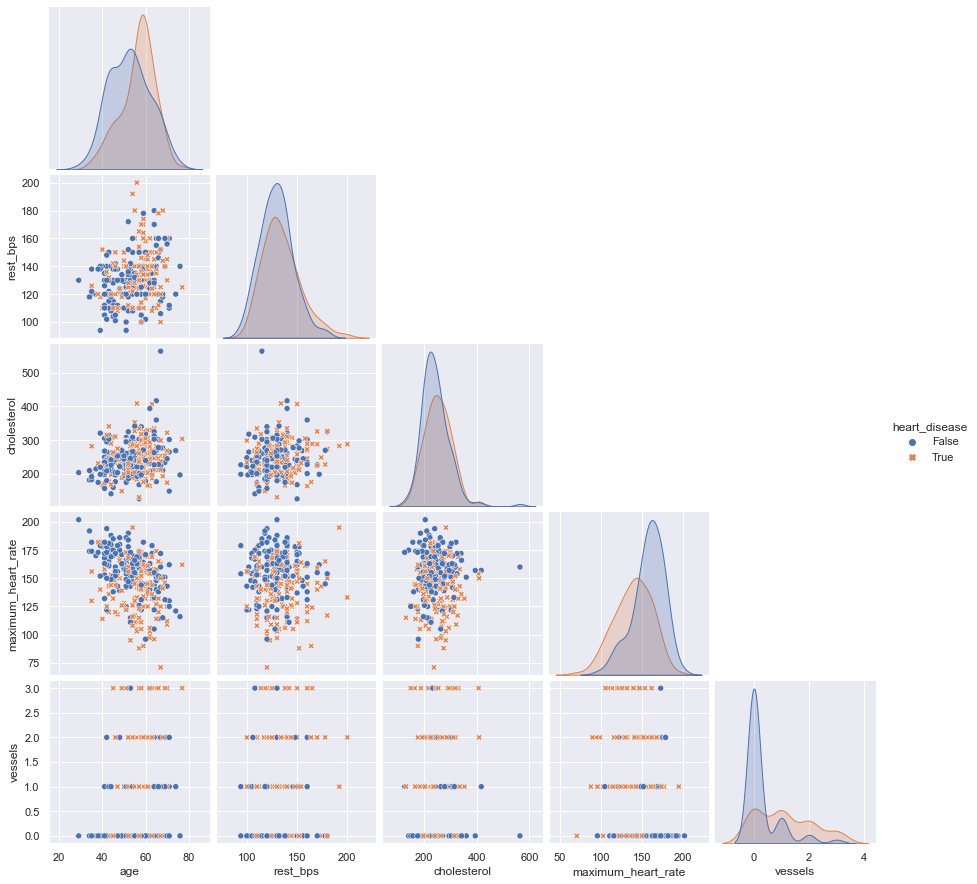

In [12]:
plot = sns.pairplot(
    data = c_t[['age', 'rest_bps', 'cholesterol', 'maximum_heart_rate', 'vessels', 'heart_disease']],
    hue = 'heart_disease',
    markers = True,
    corner = True
)


## Step 2 - K-means

In [13]:
# three categorical against five numeric
# 'chest_pain', 'rest_ecg', 'heart_disease'
# 'age', 'rest_bps', 'cholesterol', 'maximum_heart_rate', 'vessels'

But First...

In case you were unaware, it is important to scale your data. So that when clustering different types of data, they are compared with relatively the same magnitude. This means larger values will not simply eclipse other ones.

In [14]:
columns = ['age', 'rest_bps', 'cholesterol', 'maximum_heart_rate', 'vessels']
c_t.shape

(293, 11)

In [15]:
c_t = c_t.dropna(subset = columns).reset_index()

In [16]:
c_t

index  age  female        chest_pain  rest_bps  cholesterol  \
0        0   57   False      asymptomatic       140          192   
1        1   56    True   atypical angina       140          294   
2        2   56   False  non-anginal pain       130          256   
3        3   44   False   atypical angina       120          263   
4        4   52   False  non-anginal pain       172          199   
..     ...  ...     ...               ...       ...          ...   
288    288   45   False    typical angina       110          264   
289    289   68   False      asymptomatic       144          193   
290    290   57   False      asymptomatic       130          131   
291    291   57    True   atypical angina       130          236   
292    292   38   False  non-anginal pain       138          175   

     high_fasting_blood_sugar     rest_ecg  maximum_heart_rate  \
0                       False       normal                 148   
1                       False  hypertrophy                 153   
2                        True  hypertrophy                 142   
3                       False       normal                 173   
4                        True       normal                 162   
..                        ...          ...                 ...   
288                     False       normal                 132   
289                      True       normal                 141   
290                     False       normal                 115   
291                     False  hypertrophy                 174   
292                     False       normal                 173   

     exercise_angina  vessels  heart_disease  
0              False        0          False  
1              False        0          False  
2               True        1           True  
3              False        0          False  
4              False        0          False  
..               ...      ...            ...  
288            False        0           True  
289            False        2           True  
290             True        1           True  
291            False        1           True  
292            False        0          False  

[293 rows x 12 columns]

After dropping nan values we should convert numerical value into a matrix

In [17]:
x = c_t.loc [:, columns].values
x

array([[ 57, 140, 192, 148,   0],
       [ 56, 140, 294, 153,   0],
       [ 56, 130, 256, 142,   1],
       ...,
       [ 57, 130, 131, 115,   1],
       [ 57, 130, 236, 174,   1],
       [ 38, 138, 175, 173,   0]], dtype=int64)

In [18]:
scalar = StandardScaler()

x = scalar.fit_transform(x)
x

array([[ 0.29323346,  0.4724435 , -1.04889344, -0.06246486, -0.71045244],
       [ 0.18194149,  0.4724435 ,  0.91337444,  0.15646103, -0.71045244],
       [ 0.18194149, -0.09186936,  0.18233346, -0.32517594,  0.36811007],
       ...,
       [ 0.29323346, -0.09186936, -2.22240658, -1.50737576,  0.36811007],
       [ 0.29323346, -0.09186936, -0.20242494,  1.07594979,  0.36811007],
       [-1.82131404,  0.35958093, -1.37593808,  1.03216461, -0.71045244]])

In [19]:
kmeans = KMeans(n_clusters=2)
result = kmeans.fit(x)

In [20]:
result.cluster_centers_

array([[-0.67305158, -0.33551526, -0.22322269,  0.53484781, -0.56470075],
       [ 0.68697679,  0.34245695,  0.2278411 , -0.54591363,  0.57638422]])

In [21]:
result.labels_

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0])

In [22]:
result.cluster_centers_

array([[-0.67305158, -0.33551526, -0.22322269,  0.53484781, -0.56470075],
       [ 0.68697679,  0.34245695,  0.2278411 , -0.54591363,  0.57638422]])

In [23]:
c_t[['age', 'rest_bps', 'cholesterol', 'maximum_heart_rate', 'vessels']] = scalar.fit_transform(c_t[['age', 'rest_bps', 'cholesterol', 'maximum_heart_rate', 'vessels']])

y = kmeans.fit_predict(c_t[['age', 'rest_bps', 'cholesterol', 'maximum_heart_rate', 'vessels']])

c_t['clusters'] = y

c_t.head()

index       age  female        chest_pain  rest_bps  cholesterol  \
0      0  0.293233   False      asymptomatic  0.472444    -1.048893   
1      1  0.181941    True   atypical angina  0.472444     0.913374   
2      2  0.181941   False  non-anginal pain -0.091869     0.182333   
3      3 -1.153562   False   atypical angina -0.656182     0.316999   
4      4 -0.263226   False  non-anginal pain  2.278245    -0.914228   

   high_fasting_blood_sugar     rest_ecg  maximum_heart_rate  exercise_angina  \
0                     False       normal           -0.062465            False   
1                     False  hypertrophy            0.156461            False   
2                      True  hypertrophy           -0.325176             True   
3                     False       normal            1.032165            False   
4                      True       normal            0.550528            False   

    vessels  heart_disease  clusters  
0 -0.710452          False         0  
1 -0.710452          False         0  
2  0.368110           True         1  
3 -0.710452          False         0  
4 -0.710452          False         0

## Step 3 - Confusion Matrix

Produce a confusion matrix (2x2) and associated heatmap that compares ground truth values (i.e. heart_disease) against predicted values.

In [24]:
c_t.groupby(['heart_disease',  'clusters']).size()

heart_disease  clusters
False          0           113
               1            46
True           0            35
               1            99
dtype: int64

In [25]:
def apply_pred(x):
    m = [True, False]
    return m[x]

In [26]:
c_t['prediction'] = c_t['clusters'].apply(apply_pred)

In [27]:
ground_tr = c_t['heart_disease'].values
pred_val = c_t['prediction'].values
y_axis = c_t['heart_disease'].unique()

In [28]:
new_data = confusion_matrix(ground_tr, pred_val, labels = y_axis)
new_data

array([[ 46, 113],
       [ 99,  35]], dtype=int64)

In [29]:
c_t

index       age  female        chest_pain  rest_bps  cholesterol  \
0        0  0.293233   False      asymptomatic  0.472444    -1.048893   
1        1  0.181941    True   atypical angina  0.472444     0.913374   
2        2  0.181941   False  non-anginal pain -0.091869     0.182333   
3        3 -1.153562   False   atypical angina -0.656182     0.316999   
4        4 -0.263226   False  non-anginal pain  2.278245    -0.914228   
..     ...       ...     ...               ...       ...          ...   
288    288 -1.042270   False    typical angina -1.220495     0.336237   
289    289  1.517445   False      asymptomatic  0.698169    -1.029656   
290    290  0.293233   False      asymptomatic -0.091869    -2.222407   
291    291  0.293233    True   atypical angina -0.091869    -0.202425   
292    292 -1.821314   False  non-anginal pain  0.359581    -1.375938   

     high_fasting_blood_sugar     rest_ecg  maximum_heart_rate  \
0                       False       normal           -0.062465   
1                       False  hypertrophy            0.156461   
2                        True  hypertrophy           -0.325176   
3                       False       normal            1.032165   
4                        True       normal            0.550528   
..                        ...          ...                 ...   
288                     False       normal           -0.763028   
289                      True       normal           -0.368961   
290                     False       normal           -1.507376   
291                     False  hypertrophy            1.075950   
292                     False       normal            1.032165   

     exercise_angina   vessels  heart_disease  clusters  prediction  
0              False -0.710452          False         0        True  
1              False -0.710452          False         0        True  
2               True  0.368110           True         1       False  
3              False -0.710452          False         0        True  
4              False -0.710452          False         0        True  
..               ...       ...            ...       ...         ...  
288            False -0.710452           True         0        True  
289            False  1.446673           True         1       False  
290             True  0.368110           True         1       False  
291            False  0.368110           True         0        True  
292            False -0.710452          False         0        True  

[293 rows x 14 columns]

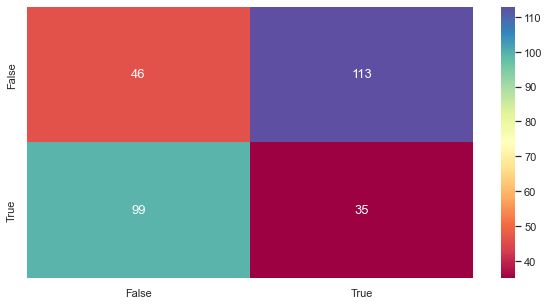

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))



heatmap = sns.heatmap(
    pd.DataFrame(new_data, columns=y_axis, index=y_axis),
    annot=True,
    fmt="d",
    annot_kws={"size":13},
    cmap="Spectral"
)

The outcome of running K-Means on this dataset can be explained in a few expressions of variables.

The variables extrapolated are shown in the graph about and the chart below.


113 True Negatives - These patients do not have heart disease and were predicted correctly

35 False Negatives - These patients have heart disease and were predicted incorrectly

46 False Positives - These patients do not have heart disease and were predicted incorrectly

99 True Positives - These patients have heart disease and were predicted correctly





In [31]:
c_t.groupby(['heart_disease', 'prediction']).size()

heart_disease  prediction
False          False          46
               True          113
True           False          99
               True           35
dtype: int64

In [32]:
c_t.sort_values(['heart_disease'])[['heart_disease', 'clusters']]

heart_disease  clusters
0            False         0
154          False         0
155          False         0
156          False         0
157          False         1
..             ...       ...
59            True         0
181           True         1
182           True         0
174           True         1
146           True         0

[293 rows x 2 columns]

# Step 4: Principal component analysis

Use PCA to find the first two principal components. The variance of each component explains its “importance” in the decomposition. By running pca = PCA(n_components=2).fit(x), you can get back the variance of each component from pca.explained_variance_.

You can then run pca.transform(x) to rotate your input features into PCA-1/PCA-2 space.

Produce a bar chart (i.e. sns.barplot) that plots the components (PCA-1, PCA-2) against their explained variance.

Produce a scatter plot of the PCA rotated heart disease data colored by cluster (i.e. K-Means resulting labels).

Describe how much variance is explained through using these components.

In [33]:
pca = PCA(n_components=2).fit(x)

In [34]:
pca.explained_variance_

array([1.81617173, 1.07593364])

In [35]:
x

array([[ 0.29323346,  0.4724435 , -1.04889344, -0.06246486, -0.71045244],
       [ 0.18194149,  0.4724435 ,  0.91337444,  0.15646103, -0.71045244],
       [ 0.18194149, -0.09186936,  0.18233346, -0.32517594,  0.36811007],
       ...,
       [ 0.29323346, -0.09186936, -2.22240658, -1.50737576,  0.36811007],
       [ 0.29323346, -0.09186936, -0.20242494,  1.07594979,  0.36811007],
       [-1.82131404,  0.35958093, -1.37593808,  1.03216461, -0.71045244]])

In [36]:
pca.transform(x)

array([[-0.27415069, -0.25765631],
       [ 0.115174  ,  1.04726795],
       [ 0.45589374, -0.19689483],
       [-1.64124702,  0.55497627],
       [-0.25015011,  1.14622878],
       [-0.72920713,  0.38272129],
       [-1.64388081, -0.27145935],
       [-0.45871626,  0.57470006],
       [-0.44526661,  0.19896444],
       [-1.05691305,  0.84502134],
       [-0.17973289, -1.06502628],
       [ 0.20217378,  1.43679926],
       [-0.31748146,  0.47596797],
       [ 0.36352645, -0.01665177],
       [ 1.17198711, -1.25368341],
       [-1.17696983, -0.3167896 ],
       [-0.24875811,  1.40918751],
       [ 1.382131  , -0.36415965],
       [-1.19259291,  1.24864016],
       [-1.46217789, -2.25130409],
       [ 1.77826994, -0.12634203],
       [ 0.50633441, -0.71763387],
       [ 0.78472634,  1.63142739],
       [-0.25937252,  0.37948078],
       [-1.73483691,  0.6555896 ],
       [-1.70126396,  0.86170606],
       [-1.13351511, -1.68932775],
       [ 1.60058315, -0.05359126],
       [ 1.15122797,

In [37]:
pca = PCA(
    n_components=2
)

principal_components = pca.fit_transform(x)

In [38]:
pcadf = pd.DataFrame(data= principal_components,
                       columns=["PCA 1", "PCA 2"])

pcadf['clusters'] = c_t['clusters']
pcadf['prediction'] = c_t['prediction']

[Text(0.5, 1.0, 'bar')]

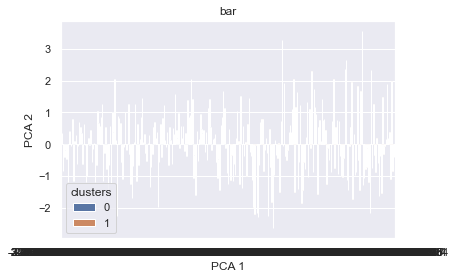

In [40]:
sns.barplot(
    data = pcadf,
    x ="PCA 1",
    y ="PCA 2",
    hue = "clusters"
).set(title="bar")

[Text(0.5, 1.0, 'bar')]

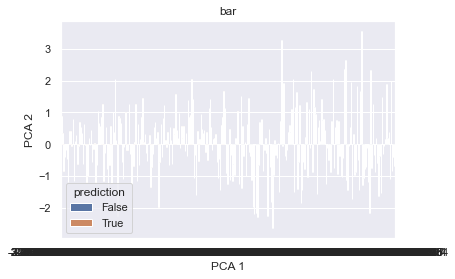

In [41]:
sns.barplot(
    data = pcadf,
    x ="PCA 1",
    y ="PCA 2",
    hue = "prediction"
).set(title="bar")

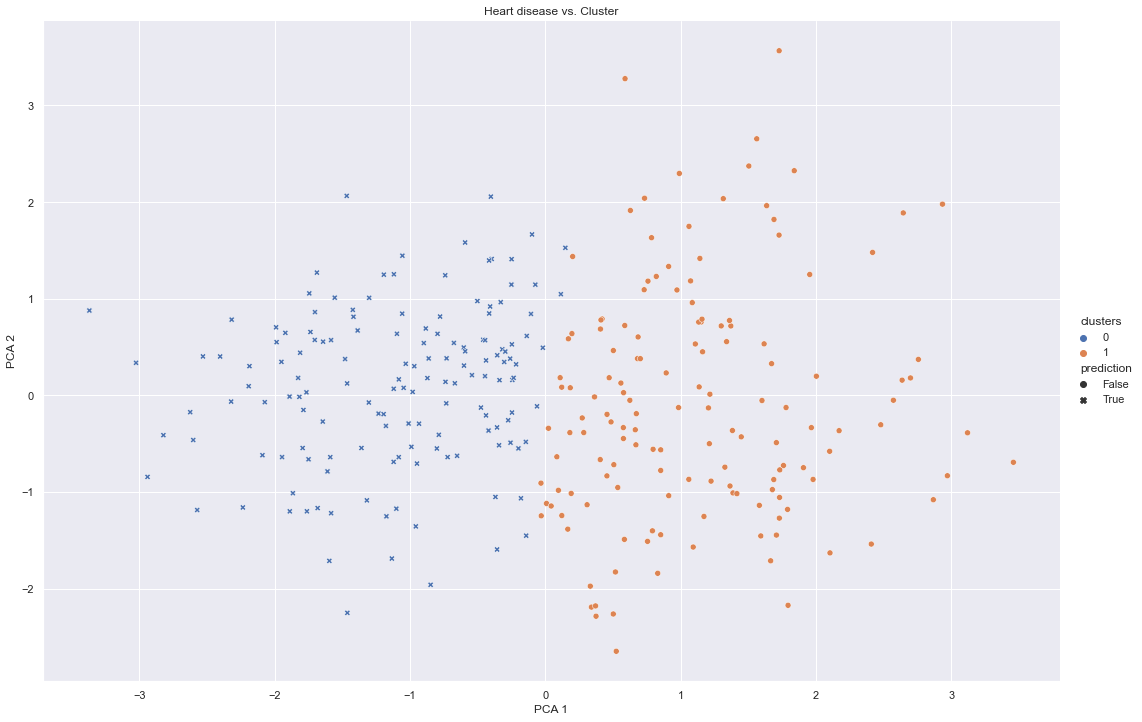

In [43]:
scatter = sns.relplot(
    data=pcadf, 
    x="PCA 1", 
    y="PCA 2", 
    kind="scatter",
    height=10,
    aspect=1.5, 
    hue="clusters",
    style="prediction",
).set(
    title="Heart disease vs. Cluster"
)

# Step 5: Discussion
How would you decribe the results of this experiment? What would you recommend to the doctors that tasked you with this problem? What could be done to improve the outcome of your model? Assuming you cannot build a perfect model, how should you optimize your model with respect to the confusion matrix analysis?

The results of this experiment are mixed. I am not entirely sure I did each part correctly.

I would reccomend to the doctors tasked me with this problem is to rely on their professional medical education. Otherwise they could probably reccomend patients they suspect have heart disease to eat a healthier diet.

The model could cerainly be improved, possibly by changing the weight of certian variables when calculating a standard scale or k-means. I imagine that some factors are more important to determining heart disease.

With respect to the confusion matrix the matrix should seek to have the most true positive values in our confusion matrix.